# Politics & Safety and Fertility — Results & Interpretation

H0: There is no linear association between the politics/safety measure (CPI10, CPI100, or WGI) and fertility (population-level TFR).

In [34]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import pearsonr, spearmanr

# Load panel from your DB
engine = create_engine("sqlite:///analytics_panel.sqlite")
panel = pd.read_sql("SELECT * FROM v_panel_all;", con=engine)

# log GDP per-capita once
panel["log_gdppc"] = np.log(panel["current_usd"]).replace([np.inf, -np.inf], np.nan)

In [35]:
#  Politics coverage

POL_VARS = ["CPI10", "CPI100", "WGI"]

# 0) Basic sanity: keep only needed columns to avoid surprises
cols_needed = ["iso_code", "year"] + [v for v in POL_VARS if v in panel.columns]
pol = panel[cols_needed].copy()

def var_coverage(df, var):
    d = df.loc[df[var].notna(), ["iso_code", "year"]]
    return {
        "variable": var,
        "countries_any": d["iso_code"].nunique(dropna=True),
        "years_any": d["year"].nunique(dropna=True),
        "min_year": (d["year"].min() if not d.empty else None),
        "max_year": (d["year"].max() if not d.empty else None),
        "non_null_rows": len(d),
    }

# 1) Per-variable coverage summary
per_var = []
for v in POL_VARS:
    if v in pol.columns:
        per_var.append(var_coverage(pol, v))
    else:
        per_var.append({
            "variable": v, "countries_any": 0, "years_any": 0,
            "min_year": None, "max_year": None, "non_null_rows": 0
        })

per_var_df = pd.DataFrame(per_var).set_index("variable").sort_index()
print("Per-variable coverage (Politics):")
display(per_var_df)

# 2) Union coverage across all Politics vars (any of CPI10/CPI100/WGI present)
any_mask = pd.Series(False, index=pol.index)
for v in POL_VARS:
    if v in pol.columns:
        any_mask = any_mask | pol[v].notna()

pol_any = pol.loc[any_mask, ["iso_code","year"]]
union_summary = {
    "union_countries_any": pol_any["iso_code"].nunique(dropna=True),
    "union_years_any": pol_any["year"].nunique(dropna=True),
    "union_min_year": (pol_any["year"].min() if not pol_any.empty else None),
    "union_max_year": (pol_any["year"].max() if not pol_any.empty else None),
    "union_non_null_rows": len(pol_any),
}
print("\nUnion coverage across CPI10/CPI100/WGI (any present):")
for k, v in union_summary.items():
    print(f"  {k}: {v}")

# 3) Optional: per-country depth (how many years per variable), with quick stats
depth_rows = []
for v in POL_VARS:
    if v not in pol.columns:
        continue
    d = pol.loc[pol[v].notna(), ["iso_code","year"]]
    per_cty = d.groupby("iso_code")["year"].nunique()
    if not per_cty.empty:
        depth_rows.append(pd.DataFrame({
            "variable": v,
            "iso_code": per_cty.index,
            "years_with_data": per_cty.values
        }))
if depth_rows:
    depth = pd.concat(depth_rows, ignore_index=True)
    stats = (
        depth.groupby("variable")["years_with_data"]
             .agg(count_countries="count",
                  median_years="median",
                  p25_years=lambda s: s.quantile(0.25),
                  p75_years=lambda s: s.quantile(0.75))
    )
    print("\nPer-country depth (years with data) — distribution by variable:")
    display(stats)


Per-variable coverage (Politics):


,countries_any,years_any,min_year,max_year,non_null_rows
variable,,,,,
CPI10,43,12,2000,2011,394
CPI100,40,13,2012,2024,492
WGI,36,25,1996,2023,270



Union coverage across CPI10/CPI100/WGI (any present):
  union_countries_any: 69
  union_years_any: 27
  union_min_year: 1996
  union_max_year: 2024
  union_non_null_rows: 1111

Per-country depth (years with data) — distribution by variable:


,count_countries,median_years,p25_years,p75_years
variable,,,,
CPI10,43,10.0,6.5,12.00
CPI100,40,13.0,13.0,13.00
WGI,36,4.5,1.0,11.25


In [36]:
# Keep minimal columns per slice
cpi10  = panel[["iso_code","year","fertility_rate","CPI10"]].dropna(subset=["fertility_rate","CPI10"])
cpi100 = panel[["iso_code","year","fertility_rate","CPI100"]].dropna(subset=["fertility_rate","CPI100"])
wgi    = panel[["iso_code","year","fertility_rate","WGI"]].dropna(subset=["fertility_rate","WGI"])


In [37]:
def corr_tests(df, x, y="fertility_rate", min_n=10):
    """Return n, Pearson r & p, Spearman rho & p for df[[y, x]]."""
    sub = df[[y, x]].dropna()
    n = len(sub)
    if n < min_n:
        return {"n": n, "pearson_r": np.nan, "pearson_p": np.nan,
                "spearman_r": np.nan, "spearman_p": np.nan}
    r_p, p_p = pearsonr(sub[y], sub[x])
    r_s, p_s = spearmanr(sub[y], sub[x])
    return {"n": n, "pearson_r": float(r_p), "pearson_p": float(p_p),
            "spearman_r": float(r_s), "spearman_p": float(p_s)}

def demean_by_country(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = out[c] - out.groupby("iso_code")[c].transform("mean")
    return out


In [38]:
# Pooled
pooled_rows = []
for label, d, col in [
    ("CPI10 (2000–2011)",  cpi10,  "CPI10"),
    ("CPI100 (2012–2024)", cpi100, "CPI100"),
    ("WGI (all years)",    wgi,    "WGI"),
]:
    pooled_rows.append({"series": label, **corr_tests(d, col)})
pooled_sig = pd.DataFrame(pooled_rows).sort_values("n", ascending=False)
pooled_sig

# Balanced windows (same eras; cap CPI100 at 2023 if you want parity)
cpi10_bal  = cpi10[(cpi10["year"] >= 2000) & (cpi10["year"] <= 2011)]
cpi100_bal = cpi100[(cpi100["year"] >= 2012) & (cpi100["year"] <= 2024)]
wgi_bal    = wgi[(wgi["year"] >= 1996)  & (wgi["year"] <= 2023)]

balanced_rows = []
for label, d, col in [
    ("CPI10 balanced",  cpi10_bal,  "CPI10"),
    ("CPI100 balanced", cpi100_bal, "CPI100"),
    ("WGI balanced",    wgi_bal,    "WGI"),
]:
    balanced_rows.append({"series": label, **corr_tests(d, col)})
balanced_sig = pd.DataFrame(balanced_rows).sort_values("n", ascending=False)
balanced_sig


,series,n,pearson_r,pearson_p,spearman_r,spearman_p
1,CPI100 balanced,441,-0.592150,4.431201e-43,-0.646295,1.654795e-53
0,CPI10 balanced,382,-0.483343,9.294564e-24,-0.555990,2.238960e-32
2,WGI balanced,270,-0.190101,1.701899e-03,-0.173353,4.277711e-03


Interpretation:

In pooled, regime-consistent windows, higher integrity/stability (higher CPI/WGI) is associated with lower fertility.

Effect sizes are moderate-to-strong for CPI (especially post-2012) and modest for WGI.

Spearman corroborates the pattern (monotonic decline), indicating the relationship is not driven by a few linear outliers.

In [39]:
within_rows = []
for label, d, col in [
    ("CPI10 within-country",  cpi10,  "CPI10"),
    ("CPI100 within-country", cpi100, "CPI100"),
    ("WGI within-country",    wgi,    "WGI"),
]:
    w = demean_by_country(d, ["fertility_rate", col])
    within_rows.append({"series": label, **corr_tests(w, col)})
within_sig = pd.DataFrame(within_rows).sort_values("n", ascending=False)
within_sig


,series,n,pearson_r,pearson_p,spearman_r,spearman_p
1,CPI100 within-country,441,-0.095352,0.045364,-0.081970,0.085547
0,CPI10 within-country,382,-0.015351,0.764890,-0.023139,0.652116
2,WGI within-country,270,-0.097407,0.110281,-0.180100,0.002979


Decision:

Reject H0 only for WGI (Spearman); borderline for CPI100 (Pearson); accept null for CPI10. Overall, within-country effects are weak (|r| ≤ 0.18). If you apply multiple-testing correction, only the WGI Spearman result is likely to remain significant.

Implication: The strong pooled correlations are largely between-country; once country fixed differences are removed, governance measures show limited year-to-year co-movement with fertility.

In [40]:
panel_sorted = panel.sort_values(["iso_code","year"]).copy()
lag_rows = []

for col in ["CPI10","CPI100","WGI"]:
    if col not in panel_sorted.columns:
        continue
    for k in (1, 2, 3):
        name = f"{col}_lag{k}"
        panel_sorted[name] = panel_sorted.groupby("iso_code")[col].shift(k)
        lag_rows.append({"series": name, **corr_tests(panel_sorted, name)})

lags_sig = pd.DataFrame(lag_rows).sort_values(["series"])
lags_sig


,series,n,pearson_r,pearson_p,spearman_r,spearman_p
3,CPI100_lag1,403,-0.604324,1.756259e-41,-0.660381,7.841848e-52
4,CPI100_lag2,365,-0.614894,2.465943e-39,-0.674703,8.217048e-50
5,CPI100_lag3,327,-0.620807,3.138875e-36,-0.685779,9.199895e-47
0,CPI10_lag1,382,-0.484985,6.242219e-24,-0.560289,5.910401e-33
1,CPI10_lag2,382,-0.488832,2.436725e-24,-0.568207,4.829639e-34
2,CPI10_lag3,382,-0.494008,6.743701e-25,-0.577184,2.597570e-35
6,WGI_lag1,259,-0.190285,2.100204e-03,-0.176008,4.495949e-03
7,WGI_lag2,248,-0.191527,2.453476e-03,-0.177487,5.059302e-03
8,WGI_lag3,237,-0.194735,2.604471e-03,-0.182114,4.918266e-03


Decision: All p < 0.05; reject H0 for every lag in CPI10, CPI100, and WGI.

Interpretation: Lagged CPI–fertility correlations are large and highly significant, mirroring contemporaneous results.

This does not imply causality: CPI/WGI are persistent and dominated by between-country differences. Large pooled lag correlations mainly reflect the same cross-sectional pattern carried backward in time, not short-run governance shocks driving fertility.

In [41]:
def partial_corr_log_gdppc(slice_df, x_col, y_col="fertility_rate"):
    m = slice_df.merge(panel[["iso_code","year","log_gdppc"]], on=["iso_code","year"], how="left")
    m = m[[y_col, x_col, "log_gdppc"]].dropna()
    n = len(m)
    if n < 10:
        return {"n": n, "partial_r": np.nan, "partial_p": np.nan}
    # Residualize y and x on log_gdppc
    b1y, b0y = np.polyfit(m["log_gdppc"], m[y_col], 1); y_res = m[y_col] - (b1y*m["log_gdppc"] + b0y)
    b1x, b0x = np.polyfit(m["log_gdppc"], m[x_col], 1); x_res = m[x_col] - (b1x*m["log_gdppc"] + b0x)
    r, p = pearsonr(y_res, x_res)
    return {"n": n, "partial_r": float(r), "partial_p": float(p)}

pc_rows = []
for label, d, col in [
    ("CPI10 | log_gdppc",  cpi10,  "CPI10"),
    ("CPI100 | log_gdppc", cpi100, "CPI100"),
    ("WGI | log_gdppc",    wgi,    "WGI"),
]:
    pc_rows.append({"series": label, **partial_corr_log_gdppc(d, col)})

partial_sig = pd.DataFrame(pc_rows).sort_values("n", ascending=False)
partial_sig


,series,n,partial_r,partial_p
1,CPI100 | log_gdppc,441,-0.072884,0.126449
0,CPI10 | log_gdppc,382,-0.038198,0.456637
2,WGI | log_gdppc,260,-0.019006,0.760360


### Partial correlations controlling for logGDP per capita

**Decision:** All p > 0.05 → fail to reject H0 for CPI100, CPI10, and WGI.

**Interpretation:** Once we hold income level constant (log GDP per capita), governance measures add little to no independent signal for fertility in this panel. The strong pooled CPI correlations are therefore largely a between-country “development bundle” effect (income, education, urbanization, institutions), not a standalone governance effect.

# Summary

Triangulation rule (our standard):
To claim a strong Politics/Safety–fertility relationship, we require convergent significance across the three indicators—CPI10, CPI100, and WGI—and consistency across tests (pooled/balanced, within-country, and partial | log GDPpc). A lone significant result is insufficient.

Balanced (pooled within regime windows):

CPI100 (2012–2024): r ≈ −0.59, p ≪ 0.001

CPI10 (2000–2011): r ≈ −0.48, p ≪ 0.001

WGI (1996–2023): r ≈ −0.19, p < 0.01
Reject H0 for all three. Interpretation: countries with cleaner, more stable governance have lower fertility in cross-section.

Within-country (demeaned):

CPI100: r ≈ −0.10, p ≈ 0.045 (borderline; Spearman ns)

CPI10: r ≈ −0.02, p ≈ 0.76 (ns)

WGI: r ≈ −0.10, p ≈ 0.11 (Pearson ns; Spearman small but significant)
Mostly fail to reject H0. Interpretation: once country fixed differences are removed, governance shows little year-to-year co-movement with fertility.

Lags (1–3 years, pooled):

CPI10/100: large negative r (≈ −0.48 to −0.62), p ≪ 0.001

WGI: small negative r (≈ −0.19), p < 0.01
Significant—but note: CPI/WGI are persistent; large pooled lag correlations reflect between-country differences carried through time, not causal timing.

Partial correlations | log(GDPpc):

CPI100: partial r ≈ −0.07, p ≈ 0.13 (ns)

CPI10: partial r ≈ −0.04, p ≈ 0.46 (ns)

WGI: partial r ≈ −0.02, p ≈ 0.76 (ns)
Fail to reject H0 for all three. Interpretation: once income is held constant, governance adds little to no independent signal.

Conclusion (apply the triangulation rule):

We cannot claim a strong, independent Politics/Safety–fertility relationship.

While pooled correlations are sizable (especially CPI), they attenuate to near zero within countries and after controlling for log income.

Result: Politics/Safety indicators likely act as proxies for broader development (income/education/urbanization/institutions) rather than direct, short-run drivers of fertility.

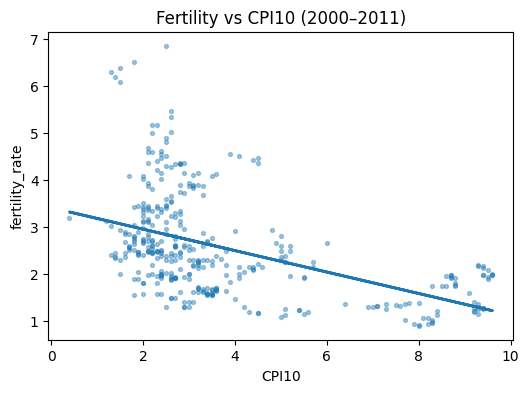

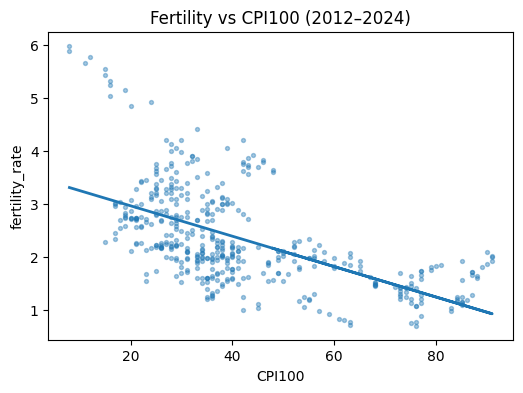

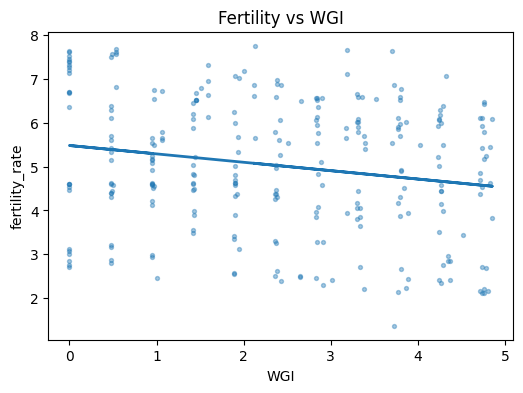

/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sub.groupby("bin")[y].mean()
/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = sub.groupby("bin")[x].mean()


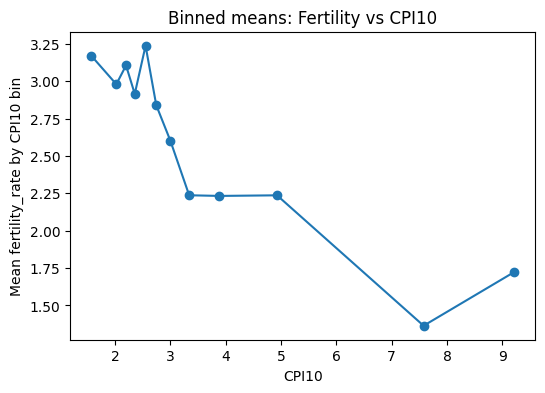

/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sub.groupby("bin")[y].mean()
/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = sub.groupby("bin")[x].mean()


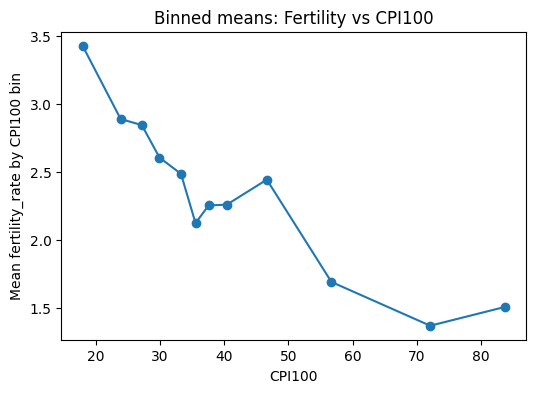

/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sub.groupby("bin")[y].mean()
/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = sub.groupby("bin")[x].mean()


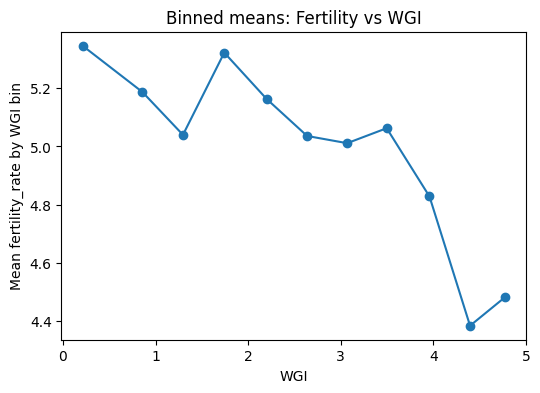

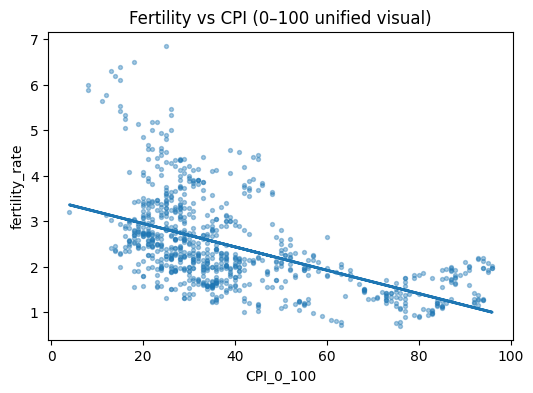

/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sub.groupby("bin")[y].mean()
/var/folders/hd/127cgs551q39p8q_90bc2rh00000gn/T/ipykernel_65707/3947282316.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = sub.groupby("bin")[x].mean()


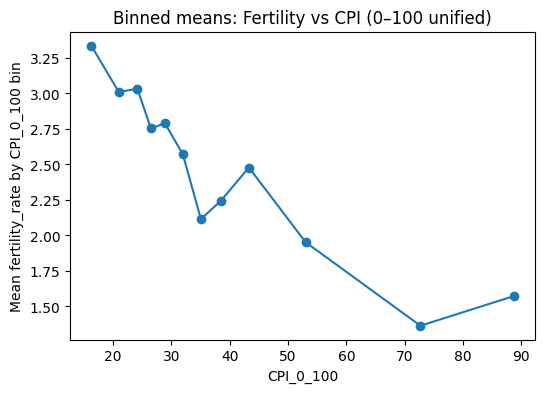

In [42]:
# Visuals (scatter + binned means)
scatter_with_fit(cpi10,  "CPI10",  title="Fertility vs CPI10 (2000–2011)")
scatter_with_fit(cpi100, "CPI100", title="Fertility vs CPI100 (2012–2024)")
scatter_with_fit(wgi,    "WGI",    title="Fertility vs WGI")

binned_line(cpi10,  "CPI10",  title="Binned means: Fertility vs CPI10")
binned_line(cpi100, "CPI100", title="Binned means: Fertility vs CPI100")
binned_line(wgi,    "WGI",    title="Binned means: Fertility vs WGI")

# Optional unified visual only (do not use for stats)
if not cpi_unified.empty:
    scatter_with_fit(cpi_unified, "CPI_0_100", title="Fertility vs CPI (0–100 unified visual)")
    binned_line(cpi_unified, "CPI_0_100", title="Binned means: Fertility vs CPI (0–100 unified)")
